Verify Tensorflow Version

In [1]:
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False
print(tf.__version__)

2.1.0


Parse csv file

In [2]:
df = pd.read_csv("jena_climate_2009_2016.csv", sep=",", skipinitialspace=True)

Detect any empty rows or columns

In [3]:
df.isna().sum()

Date Time          0
p (mbar)           0
T (degC)           0
Tpot (K)           0
Tdew (degC)        0
rh (%)             0
VPmax (mbar)       0
VPact (mbar)       0
VPdef (mbar)       0
sh (g/kg)          0
H2OC (mmol/mol)    0
rho (g/m**3)       0
wv (m/s)           0
max. wv (m/s)      0
wd (deg)           0
dtype: int64

Delete any null rows/columns and display the top of the csv file

In [4]:
df = df.dropna()
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


history_size is the size of the past window of information
target_size (our label) is how far in the future does the model need to learn to predict

In [5]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

TRAIN_SPLIT represents the number rows of data that will be used in the training dataset, the other half will be use in the valiation dataset

In [6]:
TRAIN_SPLIT = 300000
##Ensure reprdocubility
tf.random.set_seed(13)

# Univariate Time Series - Forecast using only a single feature (temperature)

In [7]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

Date Time
01.01.2009 00:10:00   -8.02
01.01.2009 00:20:00   -8.41
01.01.2009 00:30:00   -8.51
01.01.2009 00:40:00   -8.31
01.01.2009 00:50:00   -8.27
Name: T (degC), dtype: float64

array([<matplotlib.axes._subplots.AxesSubplot object at 0x0000027481050D48>],
      dtype=object)

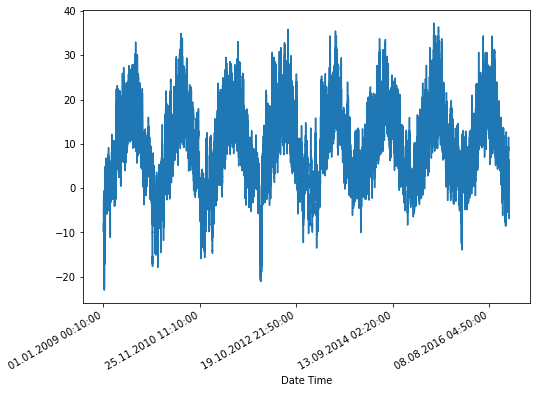

In [8]:
uni_data.plot(subplots=True)

In [9]:
uni_data = uni_data.values

Scale features before training a Neural Network. One common way is standardization, so we will subtract the mean and divide by the standard eviation of each feature. 

uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Creating the data for the univariate model.

In [10]:
univariate_past_history = 20 #This will be given the last x reported counts
univariate_future_target = 0 # Needs to learn to predict the temperature at the next time step

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

In [11]:
print ('Single window of past history')
print (x_train_uni[0])
print ('\n Target count to predict')
print (y_train_uni[0])

Single window of past history
[[-8.02]
 [-8.41]
 [-8.51]
 [-8.31]
 [-8.27]
 [-8.05]
 [-7.62]
 [-7.62]
 [-7.91]
 [-8.43]
 [-8.76]
 [-8.88]
 [-8.85]
 [-8.83]
 [-8.66]
 [-8.66]
 [-8.7 ]
 [-8.81]
 [-8.84]
 [-8.94]]

 Target count to predict
-8.94


The information given to the network is given in blue, and it must predict the value at the red cross.

In [12]:
def create_time_steps(length):
  return list(range(-length, 0))

In [13]:
def show_plot(plot_data, delta, title):
  labels = ['History', 'True Future', 'Model Prediction']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Time-Step')
  return plt

<module 'matplotlib.pyplot' from 'D:\\Users\\MSI-J\\anaconda3\\envs\\gputest\\lib\\site-packages\\matplotlib\\pyplot.py'>

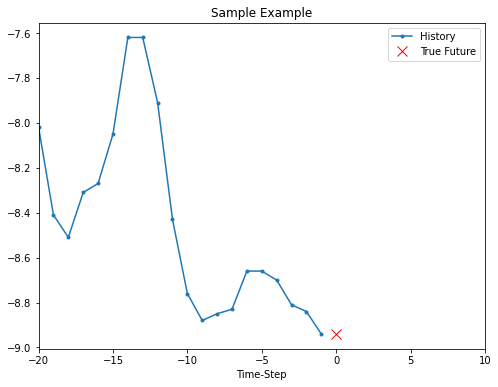

In [14]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Sample Example')

Before training a model, we nee to set a simple baseline. So given an input point, the baseline method looks through all the history and predicts the next point to be the average of the last 20 observations

In [15]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from 'D:\\Users\\MSI-J\\anaconda3\\envs\\gputest\\lib\\site-packages\\matplotlib\\pyplot.py'>

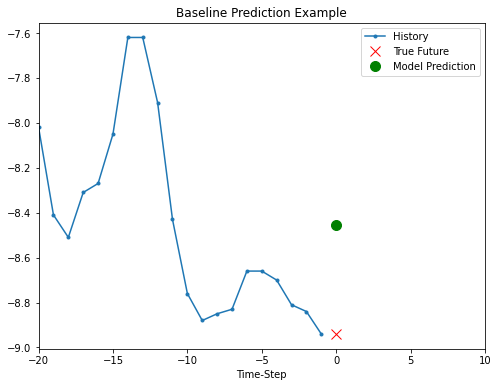

In [16]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Baseline Prediction Example')

## Now, we will use our recurrent neural network, specifically a specialized RNN layer called  Long Short Term Memory (LSTM) to beat this baseline. 

In [17]:
#Shuffle, batch, and cache the dataset

BATCH_SIZE = 256
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

In [18]:
# LSTM requires the input shape of the data it is being given
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Sample prediction

In [19]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

(256, 1)


Below we are training the moel. Each epoch will run for 200 steps

In [20]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Train for 200 steps, validate for 50 steps
Epoch 1/10
200/200 [==============================] - 4s 18ms/step - loss: 8.9702 - val_loss: 7.2886
Epoch 2/10
200/200 [==============================] - 1s 6ms/step - loss: 7.2884 - val_loss: 5.3884
Epoch 3/10
200/200 [==============================] - 1s 6ms/step - loss: 5.9007 - val_loss: 4.1960
Epoch 4/10
200/200 [==============================] - 1s 6ms/step - loss: 5.3778 - val_loss: 3.2709
Epoch 5/10
200/200 [==============================] - 1s 6ms/step - loss: 4.0948 - val_loss: 2.5503
Epoch 6/10
200/200 [==============================] - 1s 6ms/step - loss: 3.4283 - val_loss: 1.9652
Epoch 7/10
200/200 [==============================] - 1s 6ms/step - loss: 2.7302 - val_loss: 1.6293
Epoch 8/10
200/200 [==============================] - 1s 6ms/step - loss: 2.2346 - val_loss: 1.2773
Epoch 9/10
200/200 [==============================] - 1s 6ms/step - loss: 1.9732 - val_loss: 0.9319
Epoch 10/10
200/200 [==============================] - 1

Done training, now we can test it out

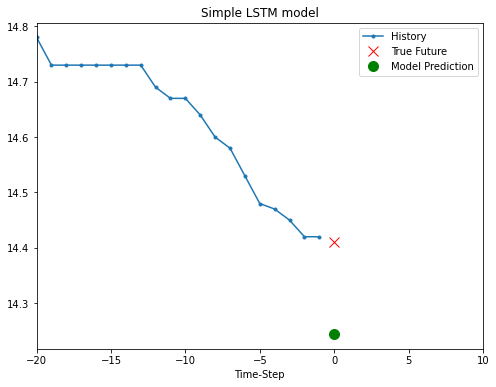

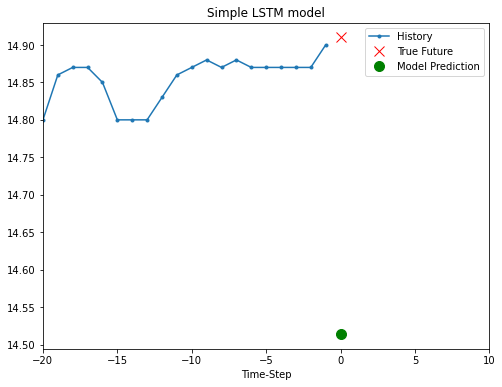

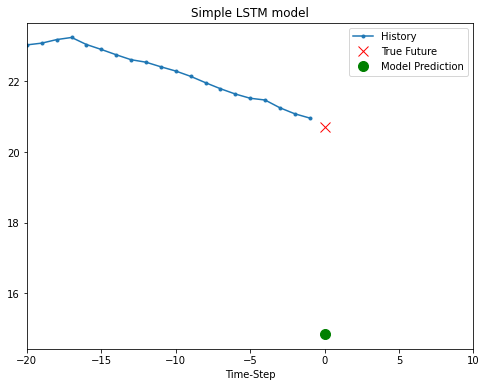

In [21]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()